In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns

## Read dataset

In [2]:
# Read data used for training and test

train = pd.read_csv('../Dataset/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../Dataset/house-prices-advanced-regression-techniques/test.csv')

## Exploratory data analysis

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


A potential issue here is that "NA" in "Alley", and in other categories is interpreted as "NaN", hence missing data, although is isn't

In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Id it's useless, I'm going to drop it!

In [5]:
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

Let's look at the correlations of the data

In [6]:
correlations_train = train.corr()

In [7]:
sns.set(font_scale=1.4)

Which variables have stronger correlation with the Sale price that we want to predict?

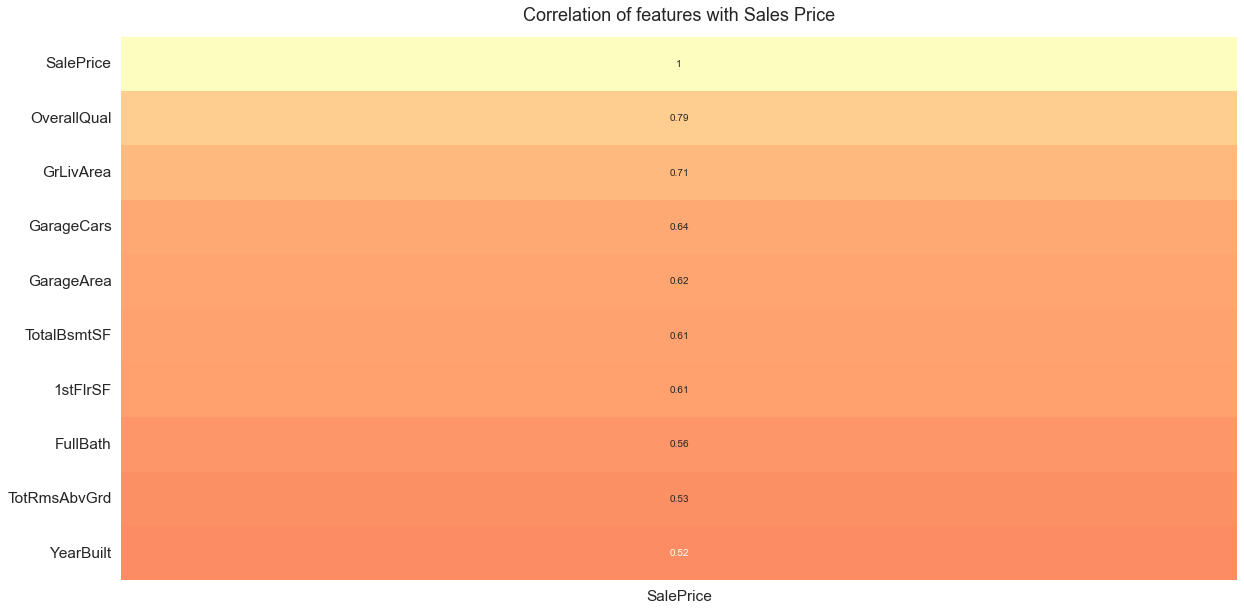

In [8]:
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(correlations_train[['SalePrice']].sort_values(by='SalePrice', ascending=False)[:10], vmin=-1, vmax=1, annot=True, cmap='magma',cbar=False)
heatmap.set_title('Correlation of features with Sales Price', fontdict={'fontsize':18}, pad=16);

This exploratory analysis revealed the most important features that drive the house prize. They are:
- Quality of the house, 
- Size,
- Cars in garage
- Bathrooms,
- etc...

Some of these feature are likely strongly correlated, such as "GarageCars" and "GarageArea"

Let's explore more this correlation between numerical features. I only show correlations larger than a threshold

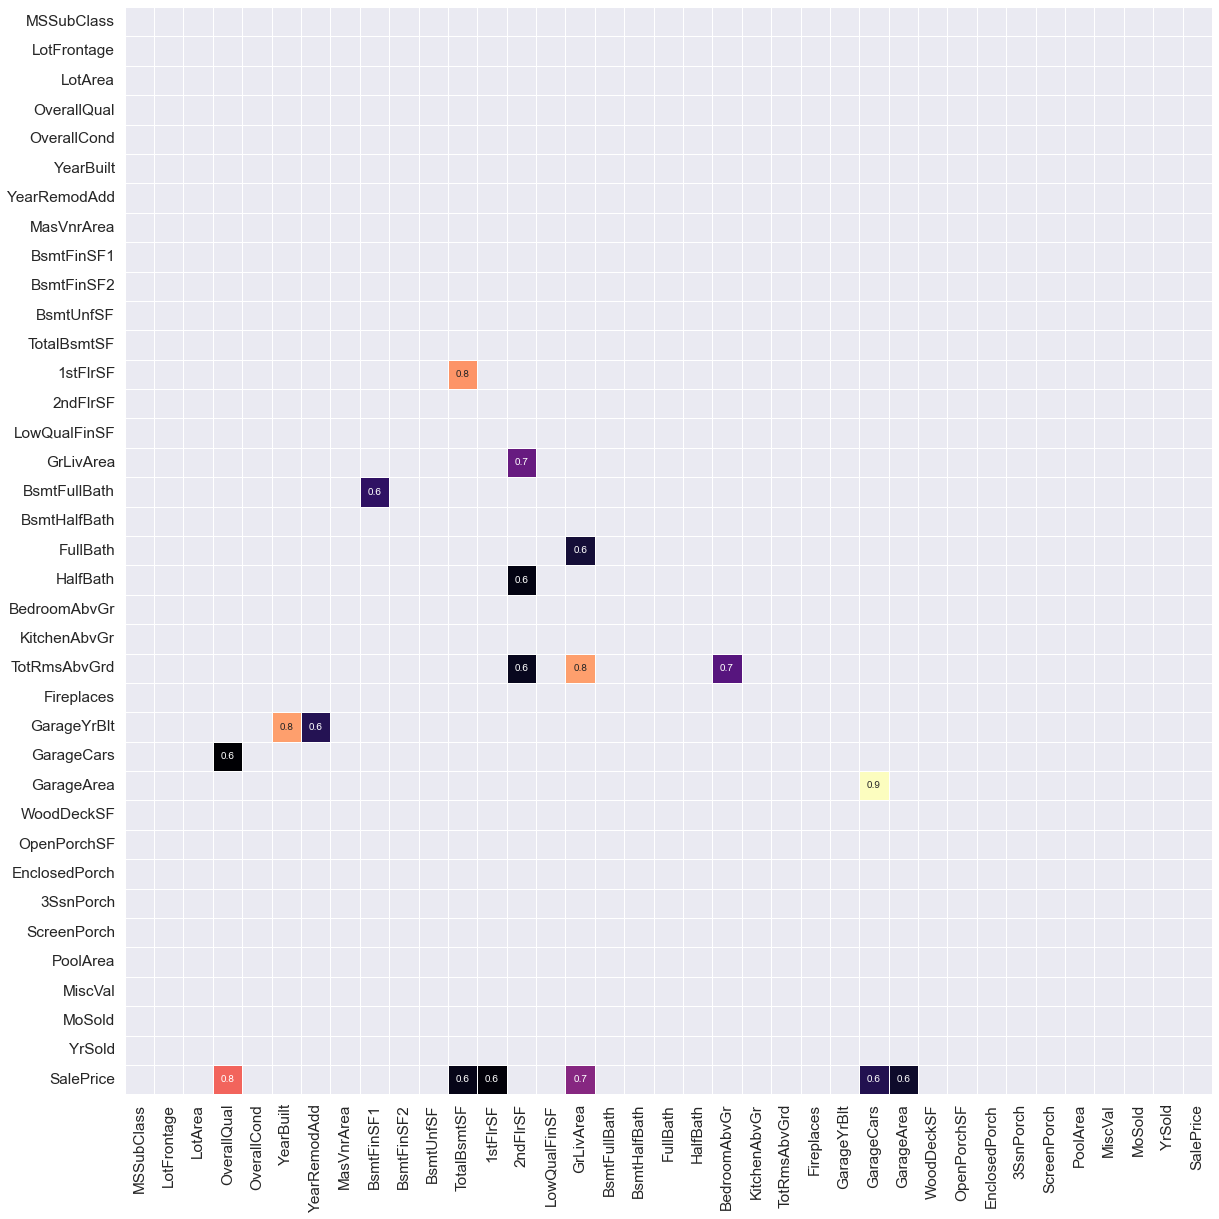

In [9]:
thresh = 0.6
filtered_correlations_train = correlations_train[((correlations_train >= thresh) | (correlations_train <= -thresh)) & (correlations_train !=1.000)]
mask = np.triu(filtered_correlations_train)
plt.figure(figsize=(20, 20))
sns.heatmap(filtered_correlations_train, annot=True, cmap="magma",cbar=False,mask = mask,square=True,fmt='.1f',linewidths=1)
plt.show()

This confirms that variables like "GarageArea" and "GarageCars" are strongly correlated. Maybe it makes sense to consider using only one of them and reduce the dimensionality of the problem

Let's look now at the importance of categorical variables for the estimating price

In [20]:
from matplotlib.ticker import MaxNLocator
def boxplots_cat(y, df):
    
    '''Create boxplots for categorical variables'''
    
    ncol = 3
    nrow = int(np.ceil(len(df.select_dtypes(include=['object']).columns)/ncol))
    
    fig, axes = plt.subplots(nrow, ncol, figsize=(6*ncol, 5*nrow))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['object']).columns, axes):

        sortd = df.groupby([i])[y].median().sort_values(ascending=False)
        sns.boxplot(x=i,
                    y=y,
                    data=df,
                    palette='magma',
                    order=sortd.index,
                    ax=j)
        j.tick_params(axis='x',labelrotation=90)
        j.tick_params(axis='y',labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=7))

        plt.tight_layout()

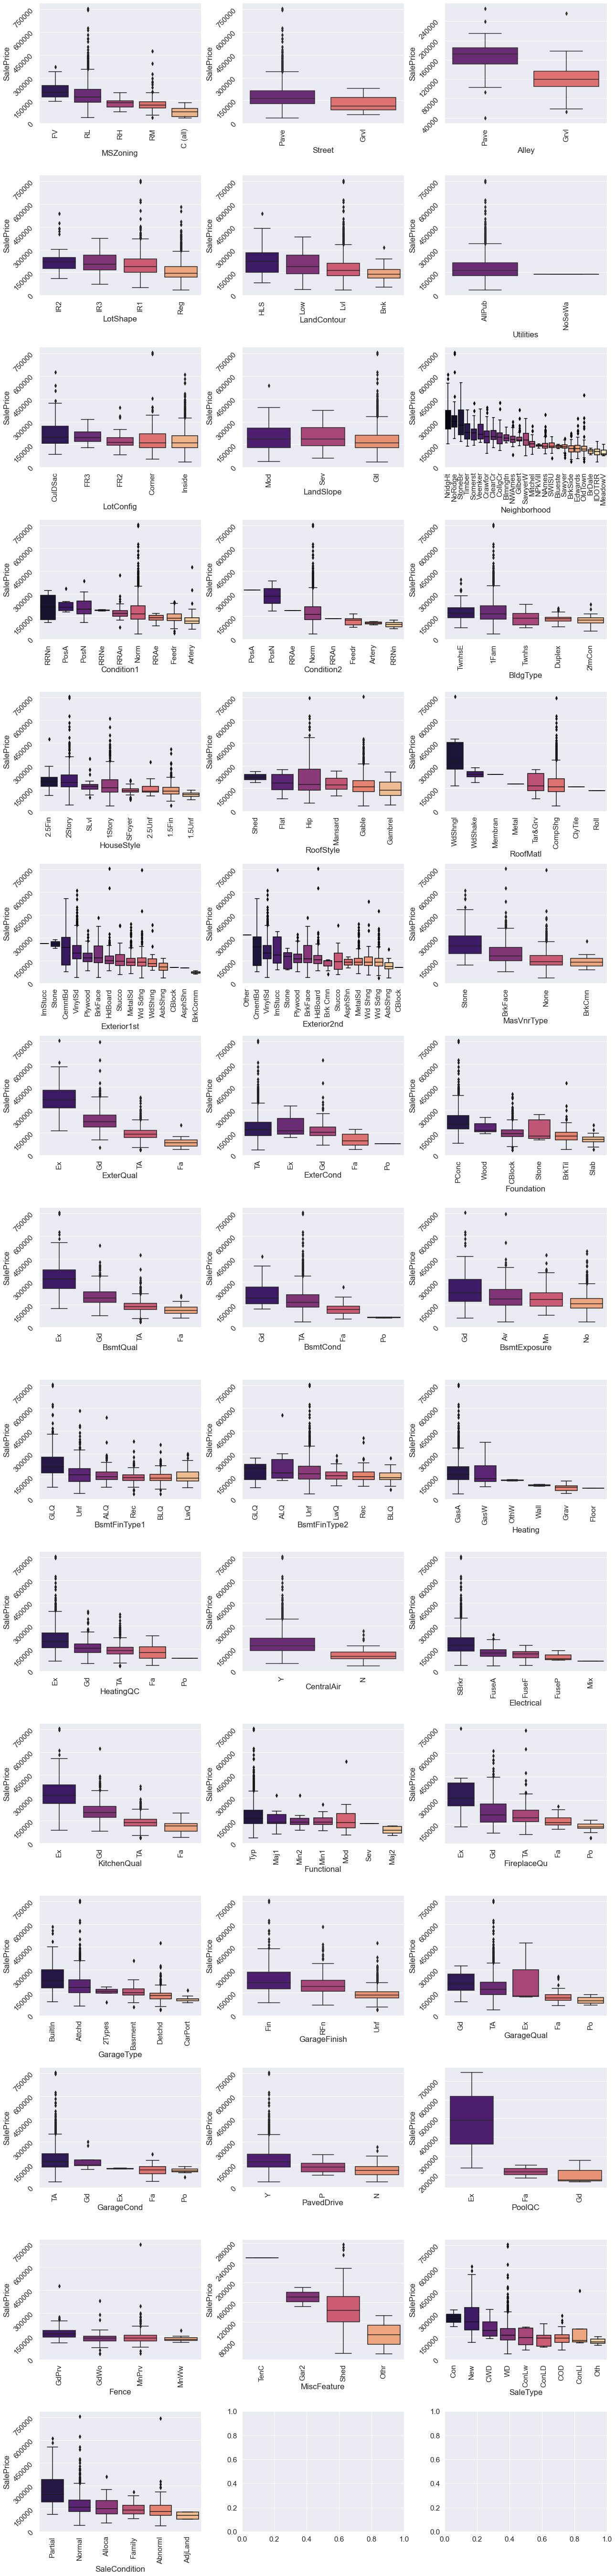

In [21]:
boxplots_cat('SalePrice', train)

Some categories like "LotConfig" and "LandSlope" don't seem to make a big difference. Maybe it's worth thinking about
reducing the dimensionality of the model by removing them

## Data preparation

Split dataset in X and y

In [22]:
y = train['SalePrice'].reset_index(drop=True)
X = train.drop(['SalePrice'], axis=1)
X = pd.concat([X,test]).reset_index(drop=True)

Let's deal with missing data first

In [23]:
def fraction_missing_data(df):
    
    """Compute the fraction of missing data for each variable."""
    
    # Compute the number of missing data per variable
    total = df.isnull().sum().sort_values(ascending=False)
    
    # Mask to filter cases with no missing data
    mask_missing_data = total != 0
    
    # Compute fraction of missing data
    percent = (total / len(df) * 100)[mask_missing_data]
    
    # Apply mask to filter cases with no missing data
    total = total[mask_missing_data]
    percent = percent[mask_missing_data]
    
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [25]:
missing_data = fraction_missing_data(X)

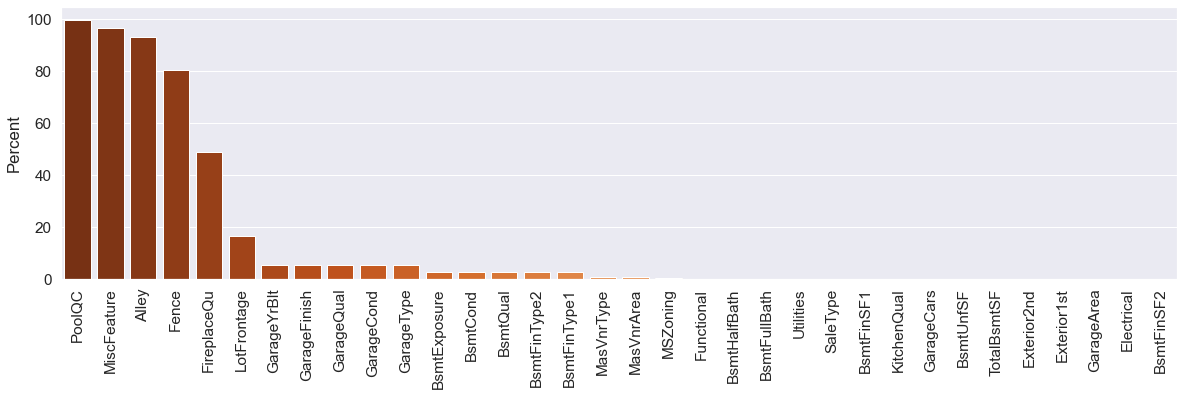

In [27]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=missing_data.index, y='Percent', data=missing_data, palette='Oranges_r')
plt.xticks(rotation=90)
plt.show()

In [29]:
X[missing_data.index]

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageYrBlt,GarageFinish,GarageQual,GarageCond,...,BsmtFinSF1,KitchenQual,GarageCars,BsmtUnfSF,TotalBsmtSF,Exterior2nd,Exterior1st,GarageArea,Electrical,BsmtFinSF2
0,NaN,NaN,NaN,NaN,NaN,65.0,2003.0,RFn,TA,TA,...,706.0,Gd,2.0,150.0,856.0,VinylSd,VinylSd,548.0,SBrkr,0.0
1,NaN,NaN,NaN,NaN,TA,80.0,1976.0,RFn,TA,TA,...,978.0,TA,2.0,284.0,1262.0,MetalSd,MetalSd,460.0,SBrkr,0.0
2,NaN,NaN,NaN,NaN,TA,68.0,2001.0,RFn,TA,TA,...,486.0,Gd,2.0,434.0,920.0,VinylSd,VinylSd,608.0,SBrkr,0.0
3,NaN,NaN,NaN,NaN,Gd,60.0,1998.0,Unf,TA,TA,...,216.0,Gd,3.0,540.0,756.0,Wd Shng,Wd Sdng,642.0,SBrkr,0.0
4,NaN,NaN,NaN,NaN,TA,84.0,2000.0,RFn,TA,TA,...,655.0,Gd,3.0,490.0,1145.0,VinylSd,VinylSd,836.0,SBrkr,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,...,0.0,TA,0.0,546.0,546.0,CmentBd,CemntBd,0.0,SBrkr,0.0
2915,NaN,NaN,NaN,NaN,NaN,21.0,1970.0,Unf,TA,TA,...,252.0,TA,1.0,294.0,546.0,CmentBd,CemntBd,286.0,SBrkr,0.0
2916,NaN,NaN,NaN,NaN,TA,160.0,1960.0,Unf,TA,TA,...,1224.0,TA,2.0,0.0,1224.0,VinylSd,VinylSd,576.0,SBrkr,0.0
2917,NaN,Shed,NaN,MnPrv,NaN,62.0,NaN,NaN,NaN,NaN,...,337.0,TA,0.0,575.0,912.0,Wd Shng,HdBoard,0.0,SBrkr,0.0


As anticipated, for some categories we seem to have missing data. In reality pandas is just misinterpreting the "NA"s.
Let's take care of them first

In [17]:
# Categories where 'NaN's mean None.

none_cols = ['Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageType',
            'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]

for col in none_cols:
    X[col].replace(np.nan, 'None', inplace=True)

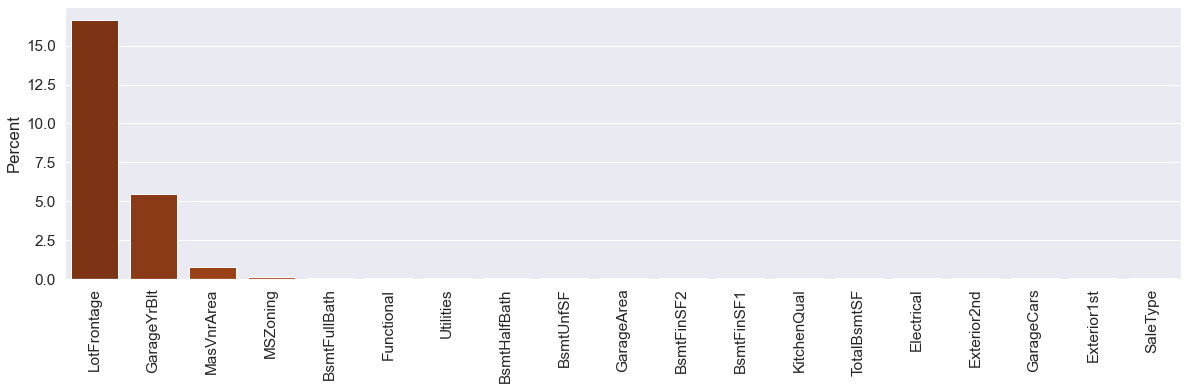

In [18]:
missing_data = fraction_missing_data(X)
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=missing_data.index, y='Percent', data=missing_data, palette='Oranges_r')
plt.xticks(rotation=90)
plt.show()

In [19]:
X[missing_data.index]

,LotFrontage,GarageYrBlt,MasVnrArea,MSZoning,BsmtFullBath,Functional,Utilities,BsmtHalfBath,BsmtUnfSF,GarageArea,BsmtFinSF2,BsmtFinSF1,KitchenQual,TotalBsmtSF,Electrical,Exterior2nd,GarageCars,Exterior1st,SaleType
0,65.0,2003.0,196.0,RL,1.0,Typ,AllPub,0.0,150.0,548.0,0.0,706.0,Gd,856.0,SBrkr,VinylSd,2.0,VinylSd,WD
1,80.0,1976.0,0.0,RL,0.0,Typ,AllPub,1.0,284.0,460.0,0.0,978.0,TA,1262.0,SBrkr,MetalSd,2.0,MetalSd,WD
2,68.0,2001.0,162.0,RL,1.0,Typ,AllPub,0.0,434.0,608.0,0.0,486.0,Gd,920.0,SBrkr,VinylSd,2.0,VinylSd,WD
3,60.0,1998.0,0.0,RL,1.0,Typ,AllPub,0.0,540.0,642.0,0.0,216.0,Gd,756.0,SBrkr,Wd Shng,3.0,Wd Sdng,WD
4,84.0,2000.0,350.0,RL,1.0,Typ,AllPub,0.0,490.0,836.0,0.0,655.0,Gd,1145.0,SBrkr,VinylSd,3.0,VinylSd,WD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,21.0,NaN,0.0,RM,0.0,Typ,AllPub,0.0,546.0,0.0,0.0,0.0,TA,546.0,SBrkr,CmentBd,0.0,CemntBd,WD
2915,21.0,1970.0,0.0,RM,0.0,Typ,AllPub,0.0,294.0,286.0,0.0,252.0,TA,546.0,SBrkr,CmentBd,1.0,CemntBd,WD
2916,160.0,1960.0,0.0,RL,1.0,Typ,AllPub,0.0,0.0,576.0,0.0,1224.0,TA,1224.0,SBrkr,VinylSd,2.0,VinylSd,WD
2917,62.0,NaN,0.0,RL,0.0,Typ,AllPub,1.0,575.0,0.0,0.0,337.0,TA,912.0,SBrkr,Wd Shng,0.0,HdBoard,WD


In [20]:
# Categories where 'NaN's mean 0.

zero_cols = [
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
    'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea'
]    

for col in zero_cols:
    X[col].replace(np.nan, 0, inplace=True)

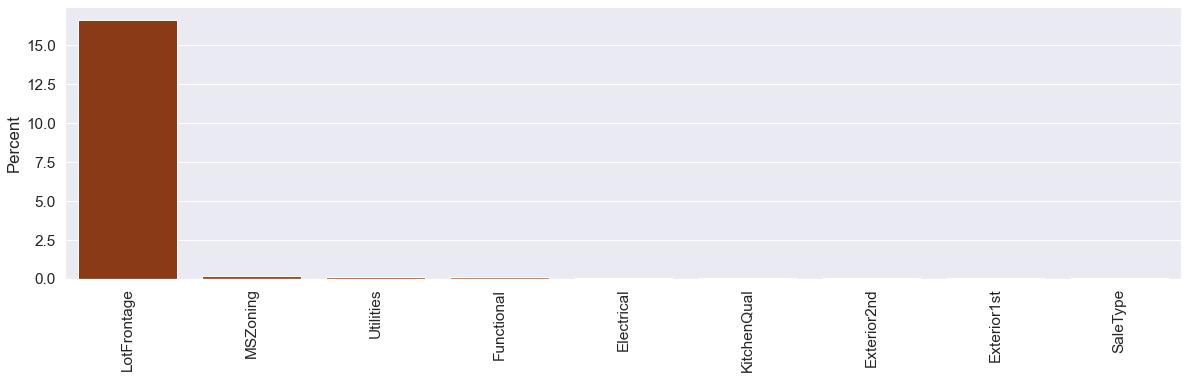

In [21]:
missing_data = fraction_missing_data(X)
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=missing_data.index, y='Percent', data=missing_data, palette='Oranges_r')
plt.xticks(rotation=90)
plt.show()

In [22]:
X[missing_data.index]

,LotFrontage,MSZoning,Utilities,Functional,Electrical,KitchenQual,Exterior2nd,Exterior1st,SaleType
0,65.0,RL,AllPub,Typ,SBrkr,Gd,VinylSd,VinylSd,WD
1,80.0,RL,AllPub,Typ,SBrkr,TA,MetalSd,MetalSd,WD
2,68.0,RL,AllPub,Typ,SBrkr,Gd,VinylSd,VinylSd,WD
3,60.0,RL,AllPub,Typ,SBrkr,Gd,Wd Shng,Wd Sdng,WD
4,84.0,RL,AllPub,Typ,SBrkr,Gd,VinylSd,VinylSd,WD
...,...,...,...,...,...,...,...,...,...
2914,21.0,RM,AllPub,Typ,SBrkr,TA,CmentBd,CemntBd,WD
2915,21.0,RM,AllPub,Typ,SBrkr,TA,CmentBd,CemntBd,WD
2916,160.0,RL,AllPub,Typ,SBrkr,TA,VinylSd,VinylSd,WD
2917,62.0,RL,AllPub,Typ,SBrkr,TA,Wd Shng,HdBoard,WD


In [23]:
# Categories where 'NaN's are actually missing data. I replace the categorical ones with the mode
# the numerical one (LotFrontage) I replace with the median

freq_cols = [
    'Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual',
    'SaleType', 'Utilities','MSZoning'
]

In [24]:
for col in freq_cols:
    X[col].replace(np.nan, X[col].mode()[0], inplace=True)

X['LotFrontage'].replace(np.nan, X['LotFrontage'].median(), inplace=True)

Let's drop the useless categories I found before

In [25]:
X.drop(['LotConfig','LandSlope','GarageArea'],axis=1,inplace=True)

Let's find the categorical variables to encode them

In [26]:
# Find the categorical columns

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

# OneHot encoding of the categorical variables
## Find indices associated to categorical variables
indices_of_categorical_columns = np.array([np.where(X.keys() == key)[0][0] for key in categorical_columns])
## Apply OneHot encoding
X = X.values
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse=False), indices_of_categorical_columns)], remainder='passthrough')
X = np.array(ct.fit_transform(X))

After taking care of missing data, let's plit again Xs in train and test set for submission

In [27]:
X = X[:len(y), :]
X_test_submission = X[len(train):, :]

Convert the house price in its log, as we want to optimize this quantity

In [28]:
y = np.log10(y.values)

In [29]:
# Split variables in training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Fit using random forest regression

In [30]:
from sklearn.ensemble import RandomForestRegressor

In [31]:
rfr = RandomForestRegressor(n_estimators=10,random_state=0)

In [32]:
rfr.fit(X_train,y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

## Compare against the test set

In [33]:
from sklearn.metrics import r2_score

In [34]:
y_predict = rfr.predict(X_test)
r2 = r2_score(y_test,y_predict)

(60, 800)

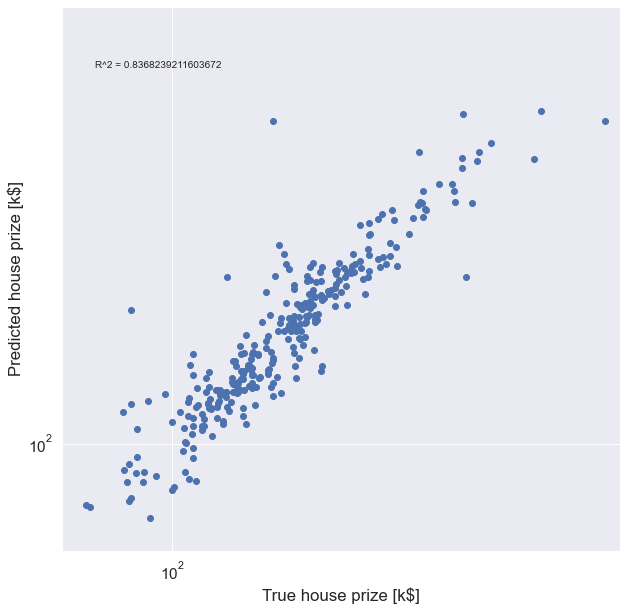

In [35]:
plt.figure(figsize=(10,10))
plt.scatter(10**(y_test)/10**3,10**(y_predict)/10**3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('True house prize [k$]')
plt.ylabel('Predicted house prize [k$]')
plt.text(70,600,f'R^2 = {r2}')
plt.xlim(60,800)
plt.ylim(60,800)

Text(0, 0.5, 'counts')

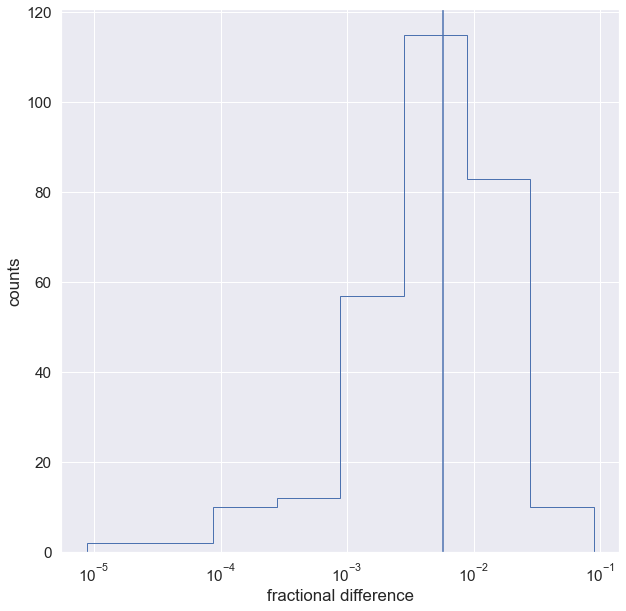

In [36]:
fractional_difference = np.abs((y_predict-y_test)/y_test)
plt.figure(figsize=(10,10))
bins = np.logspace(np.log10(np.min(fractional_difference)),np.log10(np.max(fractional_difference)),num=int(len(fractional_difference)/30))
plt.hist(fractional_difference,bins=bins,histtype='step')
plt.axvline(np.median(fractional_difference))
plt.xscale('log')
plt.xlabel('fractional difference')
plt.ylabel('counts')